# Moscow Housing

[Kaggle Competition](https://www.kaggle.com/c/moscow-housing-tdt4173/)

## Requirements

- pandas
- geopandas
- matplotlib
- catboost
- contextily
- mapclassify (for "scheme" when plotting maps)
- numpy
- lightgbm
- sklearn
- seaborn
- xgboost

## Notes

I thing "age" would be a more useful indicator than the year the building was "constructed".

The test data has some buildings far outside of Moscow.

## Setup

In [1]:
import time
import pandas as pd
import geopandas
import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import contextily
import seaborn as sns
#import xgboost
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Read data files into pandas DataFrames
apt_train = pd.read_csv("resources/data/apartments_train.csv").set_index("id")
apt_test = pd.read_csv("resources/data/apartments_test.csv").set_index("id")
bui_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
bui_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")

#bui_test.at[3803, "latitude"] = 55.567715
#bui_test.at[3803, "longitude"] = 37.481512

# Convert DataFrames for buildings into GeoDataFrames
# NOTE: We assume the projection to be WGS-84 (EPSG:4326), this should probably be verified with the lecturer
bui_train = geopandas.GeoDataFrame(bui_train, geometry=geopandas.points_from_xy(bui_train.longitude, bui_train.latitude), crs="EPSG:4326")
bui_test = geopandas.GeoDataFrame(bui_test, geometry=geopandas.points_from_xy(bui_test.longitude, bui_test.latitude), crs="EPSG:4326")

In [3]:
# Combine data
print("All train apartments have an associated train building:", apt_train.building_id.isin(bui_train.index).all())
data = apt_train.join(bui_train, on="building_id")
data.head()

All train apartments have an associated train building: True


,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,geometry
id,,,,,,,,,,,,,,,,,,,,,
0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,...,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN,POINT (37.47805 55.54405)
1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,...,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0,POINT (37.66665 55.86128)
2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,...,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN,POINT (37.51534 55.66330)
3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,...,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0,POINT (37.66665 55.86128)
4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,...,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0,POINT (37.45144 55.59078)


In [4]:
# Combine test data
print("All test apartments have an associated test building:", apt_test.building_id.isin(bui_test.index).all())
data_test = apt_test.join(bui_test, on="building_id")
data_test.head()

All test apartments have an associated test building: True


,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,geometry
id,,,,,,,,,,,,,,,,,,,,,
23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,...,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0,POINT (37.54904 55.76225)
23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,...,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0,POINT (37.45265 55.59147)
23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,...,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN,POINT (37.41372 55.61702)
23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,...,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0,POINT (37.47951 55.56905)
23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,...,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0,POINT (37.34383 55.51804)


## Helpers

In [5]:
def rmsle(prediction, truth):
    return np.sqrt(mean_squared_log_error(prediction, truth))

def plot_prediction_vs_truth(prediction, truth, model_name):
    sns.set(rc={"figure.figsize": (6,6)})
    fig, ax = plt.subplots()
    ax.scatter(prediction, truth, alpha=0.75)

    #ax.set_xscale("log")
    #ax.set_yscale("log")

    limits = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])
    ]
    ax.plot(limits, limits, "r", zorder=0)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    plt.xlabel(f"{model_name} prediction")
    plt.ylabel("Ground Truth")

## Basic EDA

### Missing Data

(Code from introduction-notebook.ipynb)

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


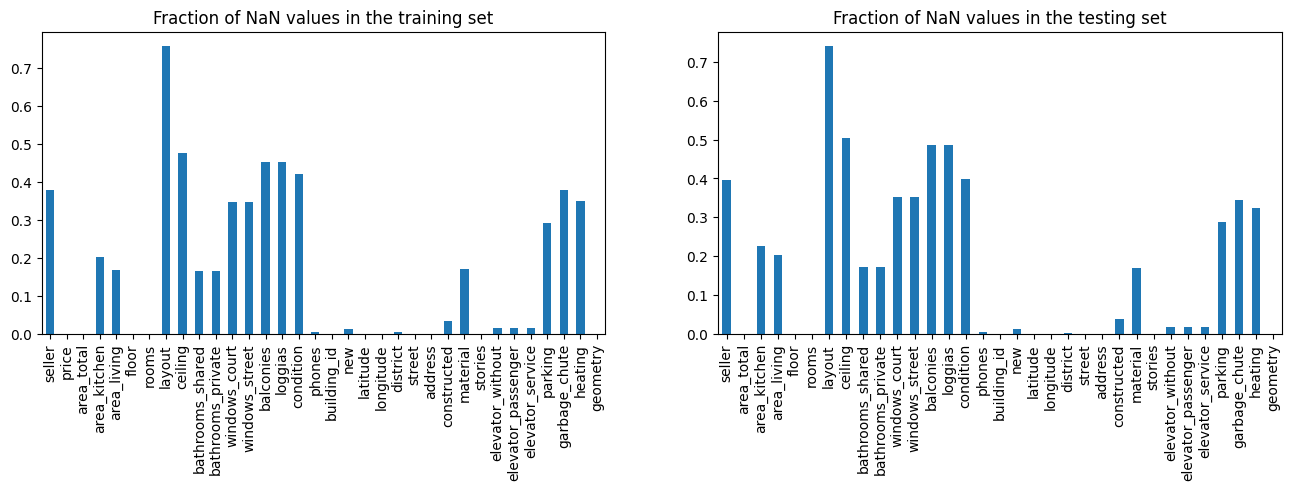

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

#### Missing Coordinates

In [7]:
missing_latlon_idx_train = bui_train[["latitude", "longitude"]].isna().any(axis=1)
print("Number of missing geographic coordinates in the training set:", missing_latlon_idx_train.sum())

missing_latlon_idx_test = bui_test[["latitude", "longitude"]].isna().any(axis=1)
print("Number of missing geographic coordinates in the training set:", missing_latlon_idx_test.sum())

Number of missing geographic coordinates in the training set: 0
Number of missing geographic coordinates in the training set: 1


In [8]:
# Show entry in the test set with missing coordinates
bui_test[missing_latlon_idx_test]

,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,geometry
id,,,,,,,,,,,,,,,,
3803,1.0,NaN,NaN,NaN,пос. Коммунарка,Москва А101 ЖК,2019.0,2.0,12.0,1.0,1.0,1.0,NaN,NaN,NaN,POINT (nan nan)


### Full Correlation Matrix

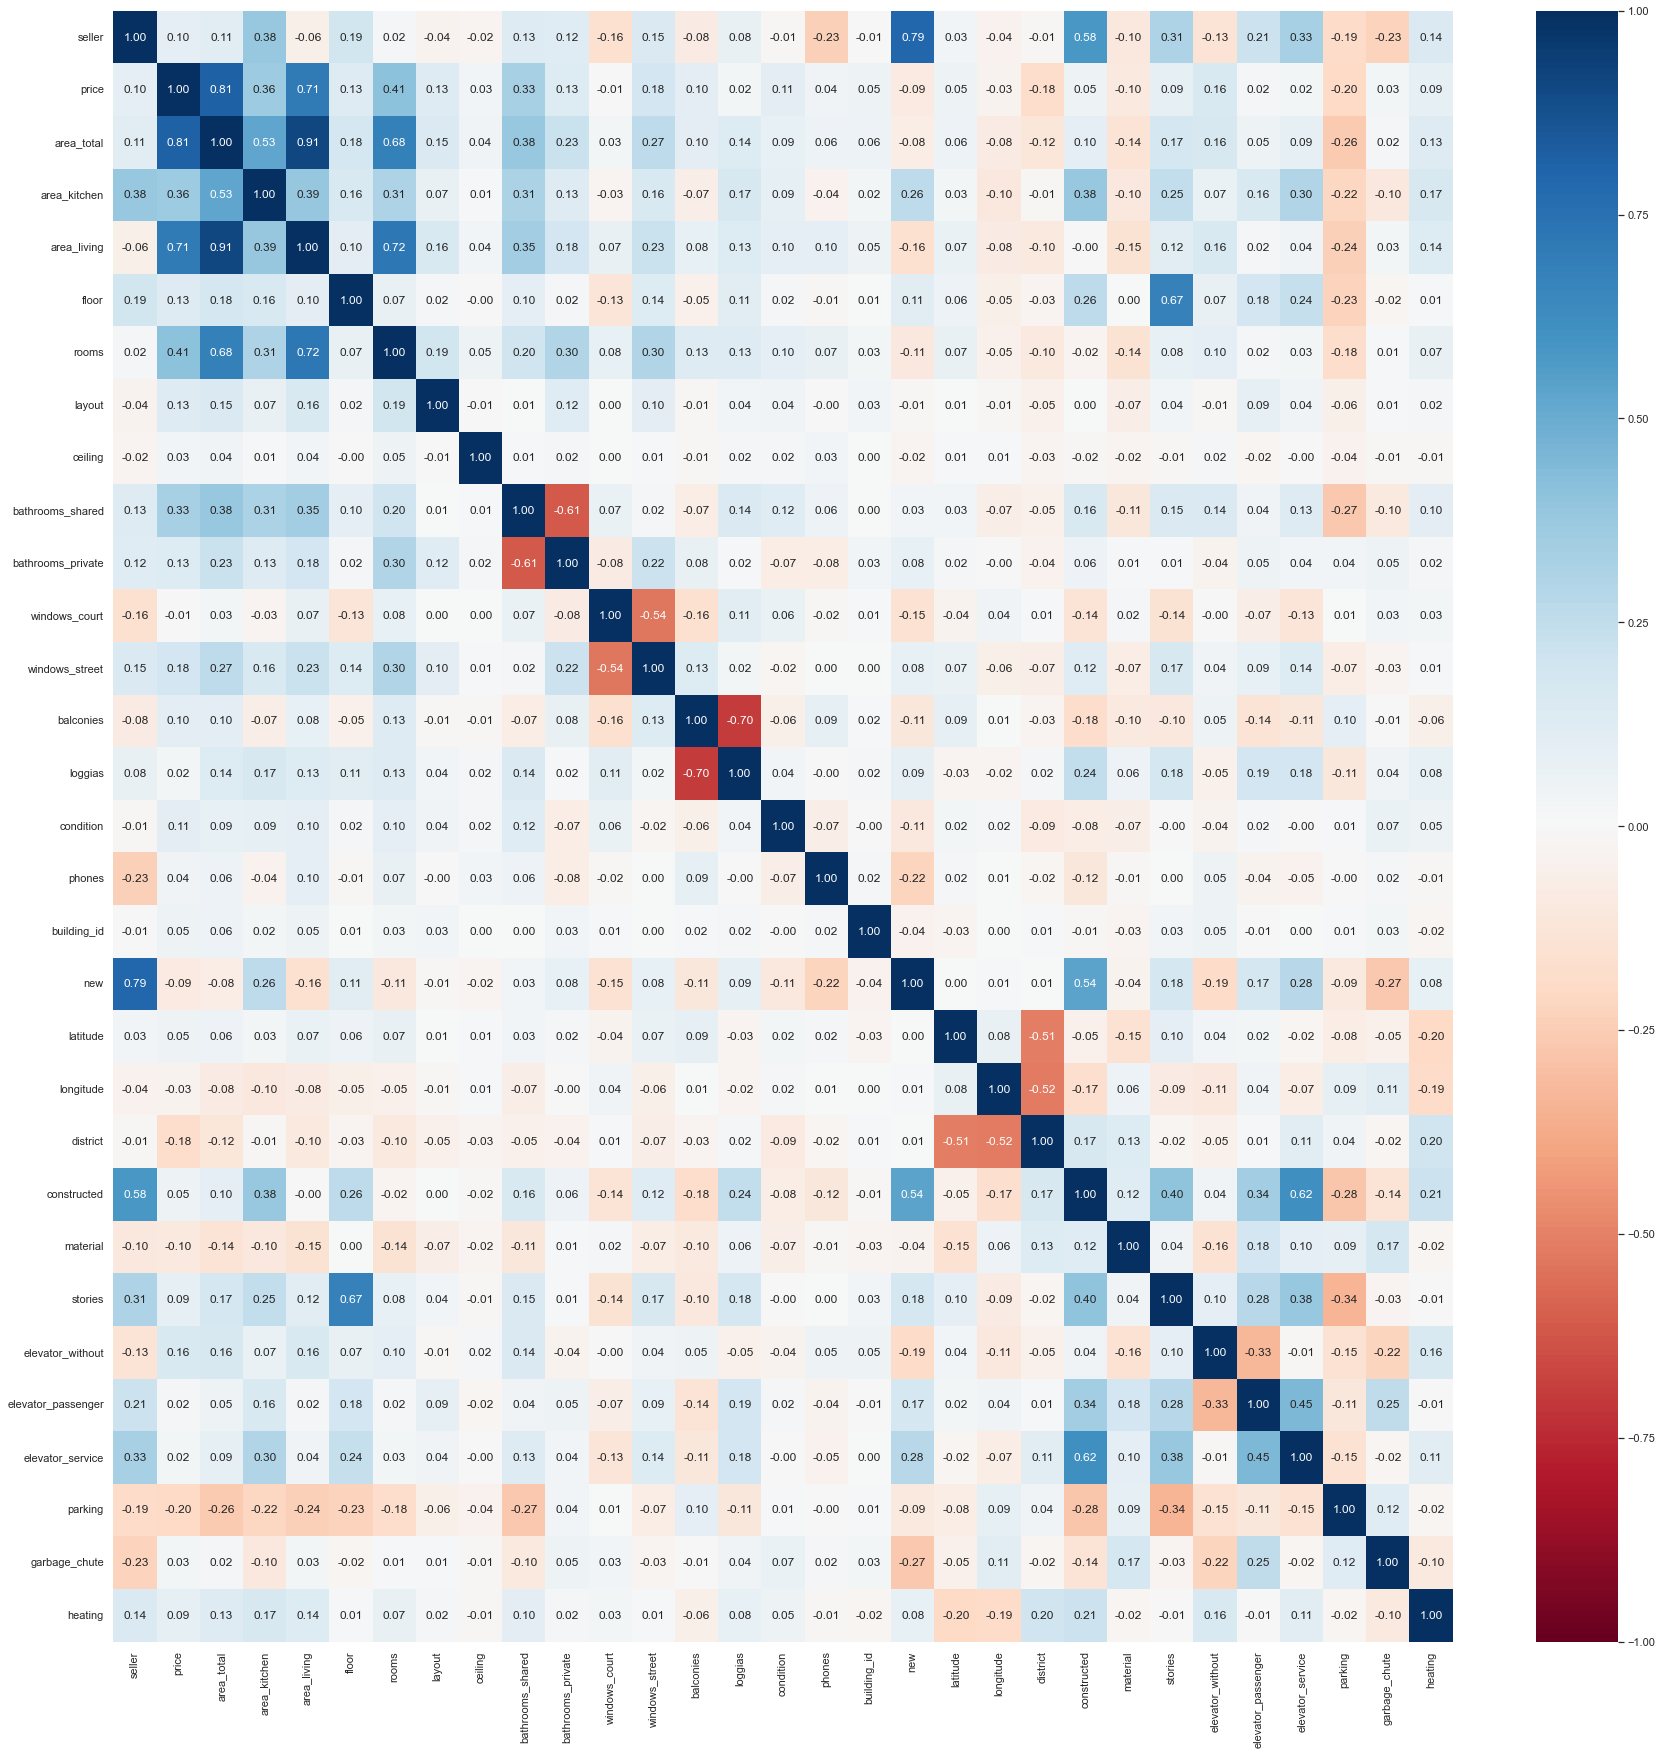

In [9]:
corr_matrix = data.corr()
sns.set(rc={"figure.figsize": (30, 30)})
sns.heatmap(corr_matrix, center=0, annot=True, fmt=".2f", cmap="RdBu", vmin=-1, vmax=1);

## Display buildings on map

TypeError: '<=' not supported between instances of 'list' and 'int'

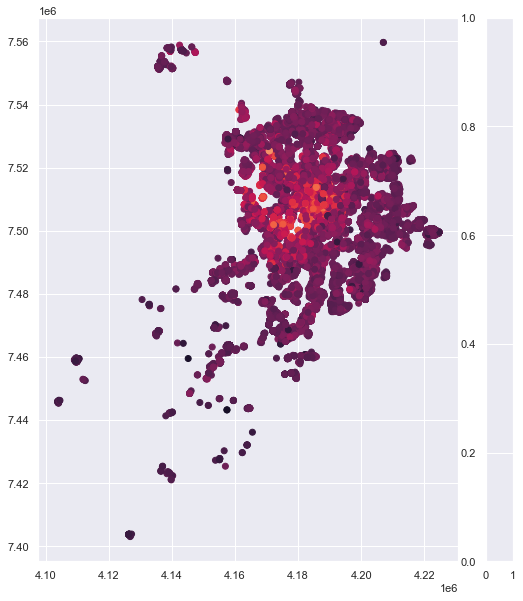

In [10]:
gdf = geopandas.GeoDataFrame(apt_train.join(bui_train, on="building_id"))
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10,10), legend=True, column="price", norm=matplotlib.colors.LogNorm(vmin=apt_train.price.min(), vmax=apt_train.price.max()))
contextily.add_basemap(ax)

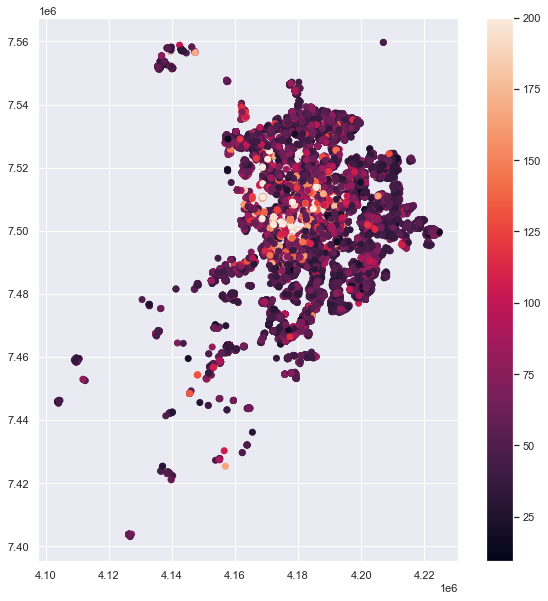

In [11]:
ax = gdf.plot(figsize=(10,10), legend=True, column="area_total", vmax=200)

In [12]:
# Read training buildings data and convert to a GeoDataFrame (we assume the projection to be WGS-84 a.k.a. EPSG:4326, this should probably be verified with the lecturer)
#bt_df = pd.read_csv("buildings_train.csv")
#bt_gdf = geopandas.GeoDataFrame(bt_df, geometry=geopandas.points_from_xy(bt_df.longitude, bt_df.latitude), crs="EPSG:4326")

# Convert to Web Mercator (EPSG:3857)
#bt_gdf_wm = bt_gdf.to_crs(epsg=3857)
#ax = bt_gdf_wm.plot(figsize=(20,20), alpha=0.5, column="constructed", edgecolor="k", legend=True)
#contextily.add_basemap(ax)

In [13]:
gdf = geopandas.GeoDataFrame(apt_test.join(bui_test, on="building_id"))
gdf.latitude.min(), gdf.latitude.max()
# Moscow ≈ 36-38, 55-57

(17.141734, 56.001625)

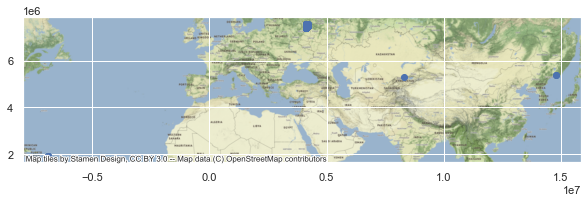

In [14]:
# Plot apartments in the testing set
gdf = geopandas.GeoDataFrame(apt_test.join(bui_test, on="building_id"))
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10,10))
contextily.add_basemap(ax)

## District Estimation

Moscow has 12 districts ([«Administrative divisions of Moscow» on Wikipedia](https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow)).

Man kan strengt tatt heller bare laste ned grensene for de ulike distriktene og fastlå riktig distrikt direkte. Ser muligens ut til at det er noen datapunkter i treningsdataene og potensielt også testdataene med feil distrikt, så da kan man ev. rette opp de også (gitt at koordinatene er riktig).

**TODO:** Dette burde egentlig gjøres direkte på `buildings` før de joines med `apartments` (slipper å kalkulere samme greia mange ganger).

In [15]:
missing_indices = data[["district"]].isna().any(axis=1)
print("Number of rows in the training set with NaN district:", missing_indices.sum())

X, y = data[["latitude", "longitude"]].loc[~missing_indices], data[["district"]].loc[~missing_indices]

# TODO: Vurder å konvertere fra lat-lon til en projeksjon som gjør koordinat-deltaer direkte sammenlignbare, UTM-sone 37U kan være et godt alternativ

Number of rows in the training set with NaN district: 130


In [16]:
fd = data[["district", "latitude", "longitude"]].loc[~missing_indices]
fd[fd.district == 1][["latitude", "longitude"]].mean()
district_centers = data.groupby("district")[["latitude", "longitude"]].mean()
district_centers

,latitude,longitude
district,,
0.0,55.754335,37.599794
1.0,55.828846,37.540468
2.0,55.852133,37.623342
3.0,55.780465,37.784460
4.0,55.702842,37.793179
5.0,55.647336,37.656719
6.0,55.632544,37.548184
7.0,55.709977,37.466900
8.0,55.809840,37.447626


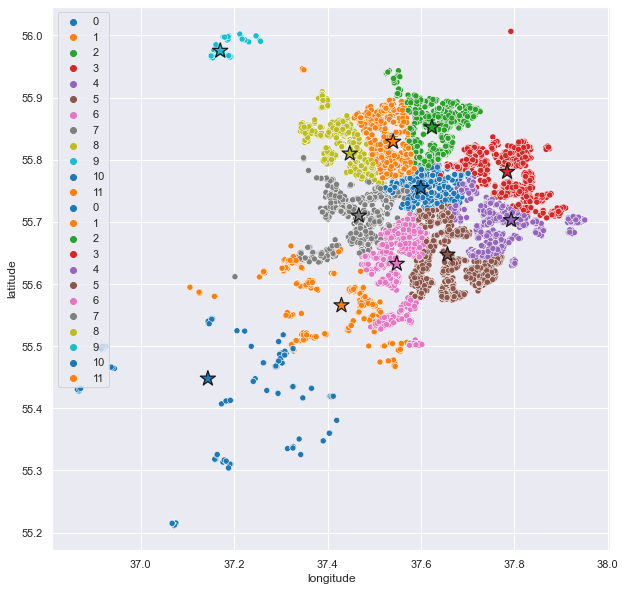

In [18]:
sns.set(rc={"figure.figsize": (10,10)})
sns.scatterplot(x="longitude", y="latitude", hue="district", hue_order=range(12), palette="tab10", data=fd)
sns.scatterplot(x="longitude", y="latitude", hue=range(12), palette="tab10", marker="*", s=250, edgecolor="k", data=district_centers);

In [19]:
#data["district_est"] = data.district
td = data[["latitude", "longitude"]].loc[missing_indices]
estd = td.apply(district_centers.dot, axis=1).apply(np.argmin, axis=1)
estd.name = "district_est"
data["district_est"] = data.district
#data["district_est"] = td.apply(district_centers.dot, axis=1).apply(np.argmin, axis=1)
#data[["district_est"]].isna().any(axis=1).sum()
#data[["district_est", "district"]].loc[missing_indices]
#data.district_est = estd
data.district_est.fillna(estd, inplace=True)
data[["district_est"]].loc[missing_indices]
# td.iloc[0]
# district_centers.dot(td.iloc[0]).argmin()
#td.apply(district_centers.dot, axis=1).apply(np.argmin, axis=1)
# data.loc[missing_indices, "district_est"]

,district_est
id,
5,10.0
27,10.0
31,10.0
40,10.0
46,10.0
...,...
22356,10.0
23114,10.0
23145,10.0


In [20]:
# Fill in data_test as well
missing_indices = data_test[["district"]].isna().any(axis=1)
latlons = data_test[["latitude", "longitude"]].loc[missing_indices]
estimated_districts = latlons.apply(district_centers.dot, axis=1).apply(np.argmin, axis=1)
data_test["district_est"] = data_test.district
data_test.district_est.fillna(estimated_districts, inplace=True)

## Estimation of shared bathrooms

In [21]:
missing_indices = data[["bathrooms_shared"]].isna().any(axis=1)
temp = data[["area_total", "bathrooms_shared"]].loc[~missing_indices]
bathroms_per_area = (temp.bathrooms_shared / temp.area_total).mean()

data["bsi"] = data["bathrooms_shared"].copy()
data["bsi"].loc[missing_indices] = data["area_total"].loc[missing_indices] * bathroms_per_area
data[["bathrooms_shared", "bsi"]]

/Users/vegardskui/Desktop/jimoskar-ml/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,bathrooms_shared,bsi
id,,
0,0.0,0.000000
1,2.0,2.000000
2,0.0,0.000000
3,0.0,0.000000
4,1.0,1.000000
...,...,...
23280,0.0,0.000000
23281,NaN,0.712759
23282,NaN,0.919447


## Test

In [22]:
# Shared Settings
random_state=42

### Split Data

In [23]:
X, y = data[["area_total", "rooms", "latitude", "longitude"]], data[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=np.log(data.price).round())

print("Number of NaNs in train:", X_train.isna().any(axis=1).sum())
print("Len(X_train)", len(X_train))

Number of NaNs in train: 0
Len(X_train) 18628


### Decision Tree

Decision Tree Test RMSLE: 0.2712


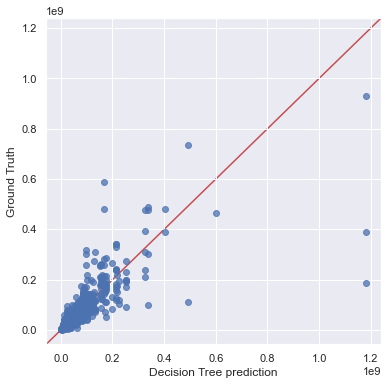

In [24]:
dt_model = DecisionTreeRegressor(
    criterion="squared_error",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=10,
    random_state=random_state
)

dt_model.fit(X_train, y_train)

dt_prediction = dt_model.predict(X_test)
dt_rmsle = round(rmsle(dt_prediction, y_test), 4)
print("Decision Tree Test RMSLE:", dt_rmsle)

plot_prediction_vs_truth(dt_prediction, y_test, "Decision Tree")

### Random Forest

Random Forest Test RMSLE: 0.171


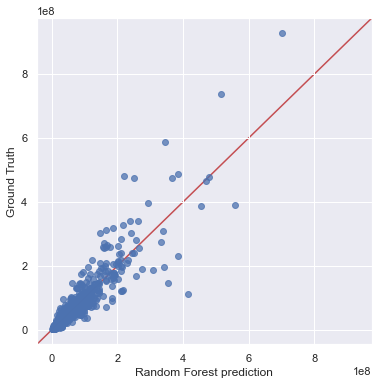

In [25]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    random_state=random_state
)

rf_model.fit(X_train, y_train.price)

rf_prediction = rf_model.predict(X_test)
rf_rmsle = round(rmsle(rf_prediction, y_test), 4)
print("Random Forest Test RMSLE:", rf_rmsle)

plot_prediction_vs_truth(rf_prediction, y_test, "Random Forest")

### Gradient Boosting Machine

Gradient Boosting Machine Test RMSLE: 0.2425


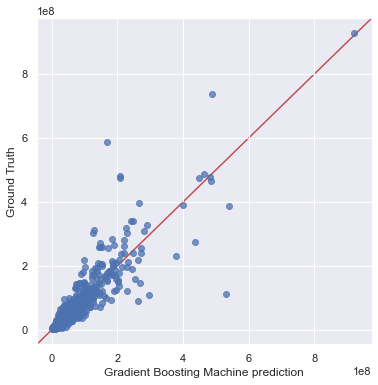

In [26]:
gbm_model = GradientBoostingRegressor(
    learning_rate=0.05,
    n_estimators=2000,
    random_state=random_state,
)

gbm_model.fit(X_train, y_train.price)

gbm_prediction = gbm_model.predict(X_test)
gbm_prediction[gbm_prediction < 0] = 0  # Remove negatives
gbm_rmsle = round(rmsle(gbm_prediction, y_test), 4)
print("Gradient Boosting Machine Test RMSLE:", gbm_rmsle)

plot_prediction_vs_truth(gbm_prediction, y_test, "Gradient Boosting Machine")

### LightGBM

LightGBM Test RMSLE: 0.4851


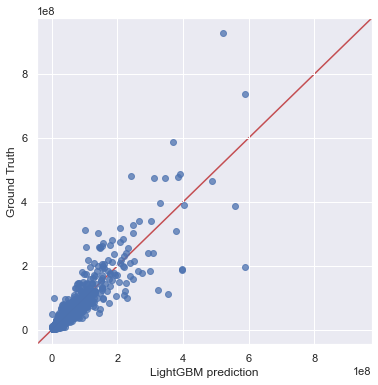

In [27]:
lgb_model = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5,
    random_state=random_state,
    silent=True,
    metric="mse",
    n_jobs=-1,
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05,
)

lgb_model.fit(X_train, y_train)

lgb_prediction = lgb_model.predict(X_test)
lgb_prediction[lgb_prediction < 0] = 0  # Remove negatives
lgb_rmsle = round(rmsle(lgb_prediction, y_test), 4)
print("LightGBM Test RMSLE:", lgb_rmsle)

plot_prediction_vs_truth(lgb_prediction, y_test, "LightGBM")

### CatBoost

CatBoost Test RMSLE: 0.2311


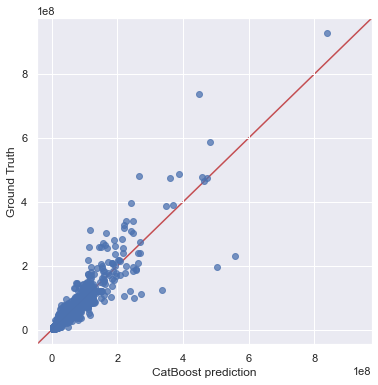

In [28]:
cat_model = CatBoostRegressor(
    silent=True,
    random_seed=random_state
)

cat_model.fit(X_train, y_train)

cat_prediction = cat_model.predict(X_test)
cat_rmsle = round(rmsle(cat_prediction, y_test), 4)
print("CatBoost Test RMSLE:", cat_rmsle)

plot_prediction_vs_truth(cat_prediction, y_test, "CatBoost")

### Stacking

In [29]:
acc = pd.DataFrame({
    "Decision Tree": dt_rmsle,
    "Random Forest": rf_rmsle,
    "Gradient Boosting Machine": gbm_rmsle,
    "LightGBM": lgb_rmsle,
    "CatBoost": cat_rmsle,
}, index=[0]).T
acc.columns = ["RMSLE"]
acc

,RMSLE
Decision Tree,0.2712
Random Forest,0.1710
Gradient Boosting Machine,0.2425
LightGBM,0.4851
CatBoost,0.2311


#### Simple Average

Simple Average Test RMSLE: 0.2039


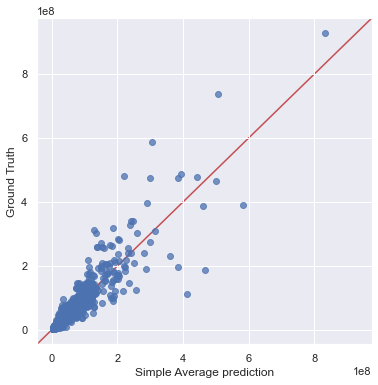

In [30]:
avg_prediction = np.mean([
    dt_prediction, rf_prediction, gbm_prediction, lgb_prediction, cat_prediction
], axis=0)
print("Simple Average Test RMSLE:", round(rmsle(avg_prediction, y_test), 4))

plot_prediction_vs_truth(avg_prediction, y_test, "Simple Average")

#### Weighted Average

Weighted Average Test RMSLE: 0.2297


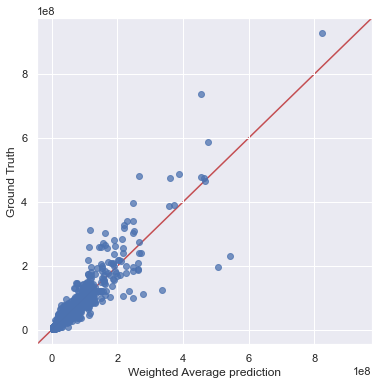

In [31]:
avg_prediction = np.average([
    # dt_prediction, rf_prediction, gbm_prediction, lgb_prediction, cat_prediction
    #rf_prediction, lgb_prediction,
    lgb_prediction, cat_prediction,
# ], weights=1/acc["RMSLE"] ** 4, axis=0)
# ], weights=1/acc["RMSLE"][[1,3]] ** 4, axis=0)
], weights=1/acc["RMSLE"][[3,4]] ** 4, axis=0)
print("Weighted Average Test RMSLE:", round(rmsle(avg_prediction, y_test), 4))

plot_prediction_vs_truth(avg_prediction, y_test, "Weighted Average")

## _Fancy_ Stacking

In [32]:
from sklearn.model_selection import KFold

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

def get_oof(clf, x_train, y_train, x_test):
    """
    Args:
        clf: classifier
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [33]:
dt_model = DecisionTreeRegressor(
    criterion="squared_error",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=10,
    random_state=random_state
)

rf_model = RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    random_state=random_state
)

lgb_model = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5,
    random_state=random_state,
    silent=True,
    metric="mse",
    n_jobs=-1,
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05,
)

cat_model = CatBoostRegressor(
    silent=True,
    random_seed=random_state
)

In [34]:
x_train = X_train.values  #X_train[["area_total", "rooms", "latitude", "longitude"]].values
x_test = X_test.values  #X_test[["area_total", "rooms", "latitude", "longitude"]].values
y_train2 = y_train.price.ravel()

In [35]:
def do_get_oof(model, x_train, y_train, x_test, name):
    start = time.time()
    oof_train, oof_test = get_oof(model, x_train, y_train, x_test)
    end = time.time()
    print(f"Completed {name} in {(end - start):.2f}s")
    return oof_train, oof_test

dt_oof_train, dt_oof_test = do_get_oof(dt_model, x_train, y_train2, x_test, "Decision Tree")
rf_oof_train, rf_oof_test = do_get_oof(rf_model, x_train, y_train2, x_test, "Random Forest")
lgb_oof_train, lgb_oof_test = do_get_oof(lgb_model, x_train, y_train2, x_test, "LightGBM")
cat_oof_train, cat_oof_test = do_get_oof(cat_model, x_train, y_train2, x_test, "CatBoost")

print("Training complete")

Completed Decision Tree in 0.20s
Completed Random Forest in 20.27s
Completed LightGBM in 3.68s
Completed CatBoost in 11.80s
Training complete


In [69]:
# rf_feature = rf_model.fit(x_train, y_train2).feature_importances_
# rf_feature

array([0.81548817, 0.01108772, 0.08451689, 0.08890722])

In [36]:
x_train3 = np.concatenate((
    #dt_oof_train,
    rf_oof_train,
    lgb_oof_train,
    cat_oof_train,
), axis=1)

x_test3 = np.concatenate((
    #dt_oof_test,
    rf_oof_test,
    lgb_oof_test,
    cat_oof_test,
), axis=1)

Final Stacked Test RMSLE: 0.1785


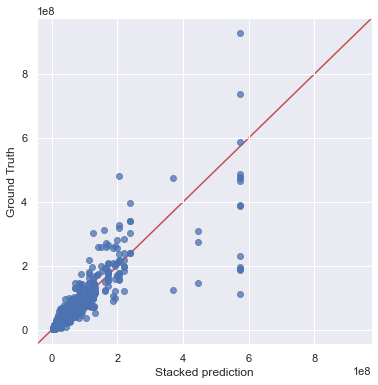

In [37]:
meta_model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=5,
    max_depth=7,
    random_state=SEED,
    silent=True,
    metric="",
    n_jobs=-1,
    n_estimators=2000,
    colsample_bytree=0.8,
    subsample=0.8,
    learning_rate=0.05,
)

meta_model.fit(x_train3, y_train2)

final_predictions = meta_model.predict(x_test3)
final_rmsle = round(rmsle(final_predictions, y_test), 4)
print("Final Stacked Test RMSLE:", final_rmsle)

plot_prediction_vs_truth(final_predictions, y_test, "Stacked")